70516185-2f60-4626-96ce-4d07d2a7e74f
0     True
1    False
Name: Key, dtype: bool
9be202dc-a672-4716-8197-40dabef8390d
0    False
1     True
Name: Key, dtype: bool
Loading dataset with dimensions
{'T': (0, 143), 'Z': (0, 1), 'C': (0, 1), 'X': (0, 212), 'Y': (0, 220)}


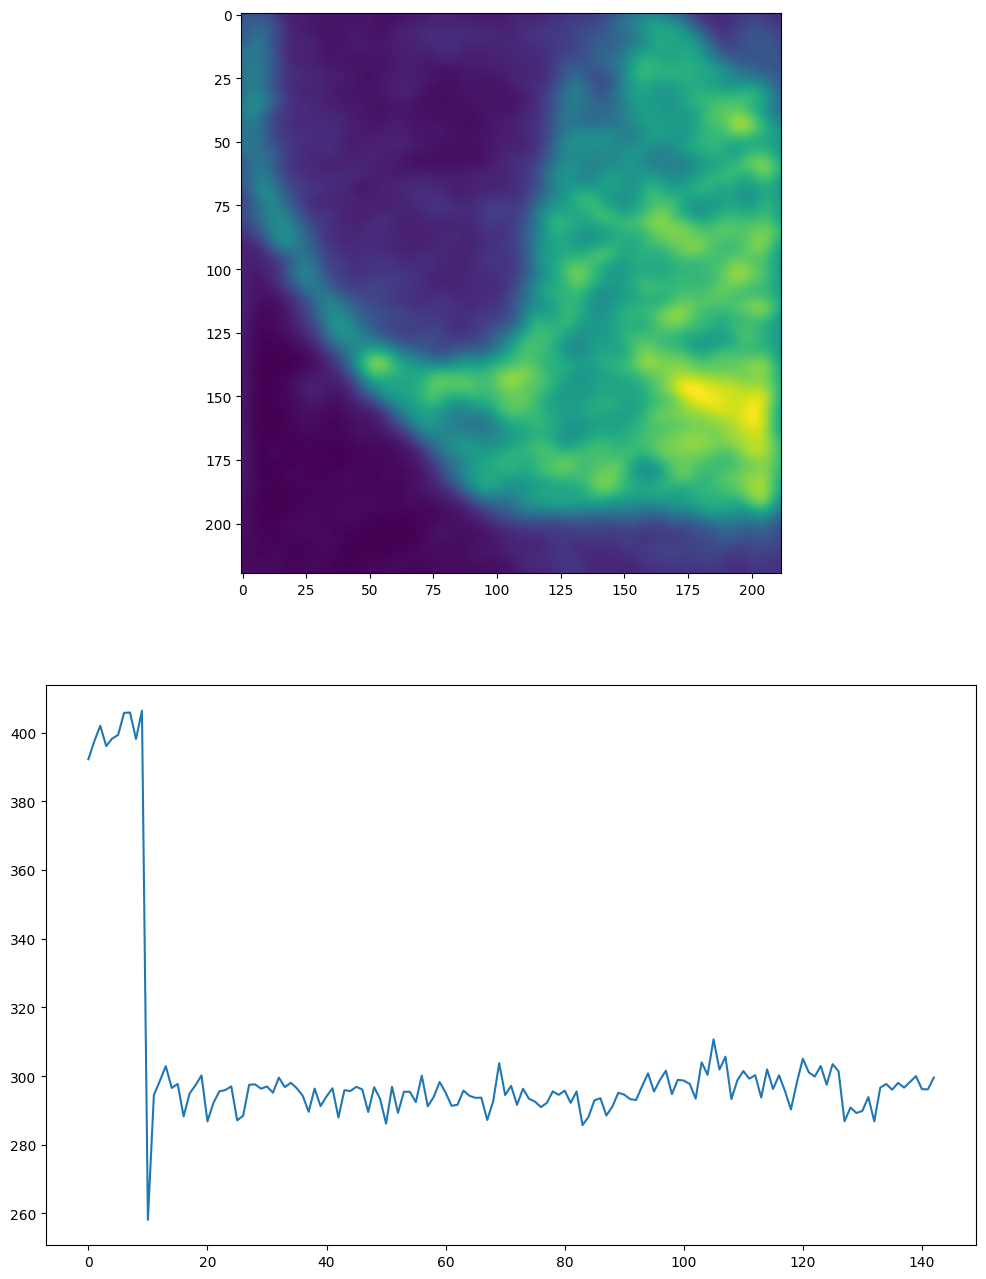

In [17]:
from pylibCZIrw import czi as pyczi
from aicspylibczi import CziFile
from aicsimageio import AICSImage
from skimage.morphology import disk
from skimage.filters import rank, threshold_otsu, gaussian

from matplotlib import pyplot as plt

import xml.etree.ElementTree as ET
import pandas as pd
from io import StringIO
import numpy as np

cziPath = "D:\\Projects\\Shannon\\FRAP analysis\\images\\test\\dish1_ASS1WT_0mMH2O2_0mMNAC-#roi-09-Airyscan Processing-02.czi"
czi = AICSImage(cziPath)


with pyczi.open_czi(cziPath) as czidoc:

        md_xml = czidoc.raw_metadata
        root = ET.fromstring(md_xml)
meta = czi.metadata 
md_xml = ET.tostring(meta,encoding="unicode")
pxSize = czi.physical_pixel_sizes      
regions = pd.read_xml(StringIO(md_xml), xpath=".//RegionItem", attrs_only = False, elems_only = False,parser="etree")   
geo = pd.read_xml(StringIO(md_xml), xpath=".//RegionItem/GraphicProperties/Geometry", elems_only = True, parser="etree")
annotations_id = pd.read_xml(StringIO(md_xml), xpath=".//Layers/Layer/Elements/Rectangle/Attributes", elems_only = True, parser="etree")   
annotations = pd.read_xml(StringIO(md_xml), xpath=".//Layers/Layer/Elements/Rectangle/Geometry", elems_only = False, parser="etree")
bleaching_info = pd.read_xml(StringIO(md_xml), xpath=".//TimelineTrack/TimelineElements/TimelineElement/Bounds", attrs_only = False, elems_only = False, parser="etree")    
bleaching_info2 = pd.read_xml(StringIO(md_xml), xpath=".//TimelineTrack[@Name='Bleaching Track']/TimelineElements/TimelineElement/Bounds", attrs_only = True, elems_only = False, parser="etree")    

a = czi.dims
#a = czi.ome_metadata

for id in  enumerate(annotations_id['UniqueName']):
       print(id[1])
       print(regions['Key']==id[1])
       i=regions[regions['Key']==id[1]].index[0]
       #regions.insert(i, 'X_roi', annotations['Left'][i])
       regions.loc[i, 'X_roi'] = annotations['Left'][i]
       regions.loc[i, 'Y_roi'] = annotations['Top'][i]
       regions.loc[i, 'Width_roi'] = annotations['Width'][i]
       regions.loc[i, 'Height_roi'] = annotations['Height'][i]
       


       


#print(annotations_id['UniqueName'][0]) 


with pyczi.open_czi(cziPath) as czidoc:
        # get the image dimensions as a dictionary, where the key identifies the dimension
        total_bounding_box = czidoc.total_bounding_box
        print('Loading dataset with dimensions')
        print(czidoc.total_bounding_box)
              
        img_data = np.zeros((total_bounding_box["T"][1],total_bounding_box["Y"][1]  ,total_bounding_box["X"][1]))
        for t in range(total_bounding_box["T"][1]):
            
            # read a 2D image plane and optionally specify planes, zoom levels and ROIs
            img_data[t,:,:] = np.squeeze(czidoc.read(plane={"T": t}, zoom=1.0))

result = pd.concat([regions, geo], axis=1) 



roi1= img_data[:, int(regions.loc[0,'Y_roi']) : int(regions.loc[0,'Y_roi'] + regions.loc[0,'Height_roi']),
               int(regions.loc[0,'X_roi']) : int(regions.loc[0,'X_roi'] + regions.loc[0,'Width_roi'])]

roimean = np.mean(roi1, axis = (1,2))
Tmean = np.mean(img_data[0:10,:,:], axis = 0, dtype = np.uint16)

Tmean_f = rank.mean(Tmean, footprint = disk(3))
Tmean_f = gaussian(Tmean, sigma=3)

th = threshold_otsu(Tmean_f)
Tmean_mask =Tmean_f>th
wcellMean = np.zeros(img_data.shape[0])
a = img_data[0,Tmean_mask] 

for t in range(img_data.shape[0]):
            wcellMean[t] = np.mean(img_data[t,Tmean_mask])  

fig, ax = plt.subplots(2, figsize=(12, 16)) 
ax[0].imshow(Tmean_f)
ax[1].plot(wcellMean)

roiData = pd.DataFrame( columns = ['timepoint','timestamp', 'bleach', 'ctrl', 'bkg'])
roiData['timepoint'] = range(img_data.shape[0])


In [ ]:
import io_tools
import numpy as np
cziPath = "D:\\Projects\\Shannon\\FRAP analysis\\images\\test\\dish1_ASS1WT_0mMH2O2_0mMNAC-#roi-09-Airyscan Processing-02.czi"
frames_metadata = io_tools.load_frame_metadata(cziPath)
frap_frame = 15
a = frames_metadata['Time[s]'][0:frap_frame]
sampling = np.mean(np.diff(frames_metadata['Time[s]'][frap_frame::]))


Reading sublocks planes: 143 2Dplanes [00:00, 923.08 2Dplanes/s]
